In [1]:
import math
import numpy as np
import h5py
import skimage.transform as sktrans
import skimage.io as skio
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

Let's read the NYU Depth dataset and view an example's image, depth and labels.

In [2]:
path_to_depth = "../data/nyu_depth_data_labeled.mat"

#refs#
<HDF5 group "/#refs#" (6544 members)>
#subsystem#
<HDF5 group "/#subsystem#" (1 members)>
accelData
<HDF5 dataset "accelData": shape (4, 2284), type "<f4">
depths
<HDF5 dataset "depths": shape (2284, 640, 480), type "<f4">
images
<HDF5 dataset "images": shape (2284, 3, 640, 480), type "|u1">
labels
<HDF5 dataset "labels": shape (2284, 640, 480), type "<u2">
names
<HDF5 dataset "names": shape (1418, 1), type "|O">
namesToIds
<HDF5 dataset "namesToIds": shape (1, 6), type "<u4">
rawDepths
<HDF5 dataset "rawDepths": shape (2284, 640, 480), type "<u2">
scenes
<HDF5 dataset "scenes": shape (1, 2284), type "|O">


c:\Users\heman\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


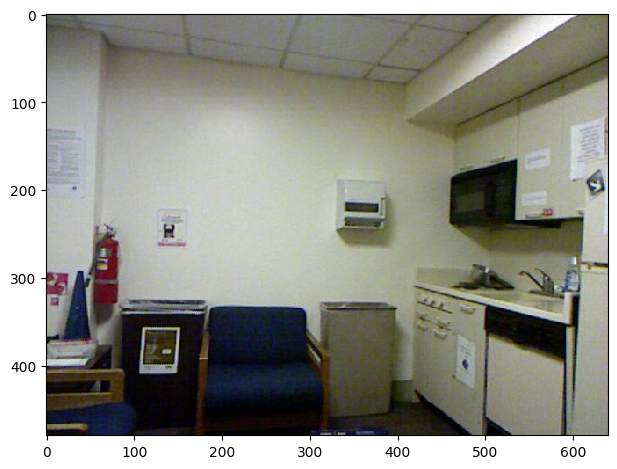

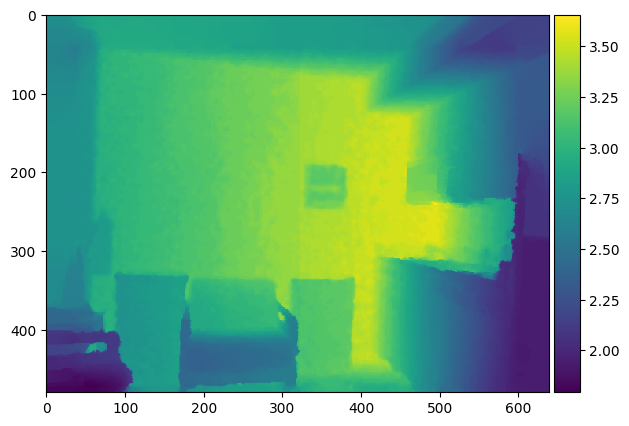

In [3]:
input_file = h5py.File(path_to_depth,"r")
for name,var in input_file.items():
    print(name)
    print(var)
im=input_file["images"][0,:,:,:]
im=np.moveaxis(im,[0,1,2],[2,1,0])
plt.figure()
skio.imshow(im)
im_depth=input_file["depths"][0,:,:]
im_depth=np.moveaxis(im_depth,[0,1],[1,0])
plt.figure()
_=skio.imshow(im_depth)

1. Thus, in the original dataset, images are in the shape **Batch x Channels x Width x Height**.
2. We will convert it to the shape **Batch x Height x Width x Channels** so that they are easy to plot.

## Generating the hazy images dataset

Our dataset generation process is borrowed from MSCNN. 

1. MSCNN uses 6000 samples from the unlabelled dataset. We restrict ourselves to the 2284 samples in the labelled dataset due to resource constraints.
2. We first remove 40 samples for validation. We don't create a separate test set. In the future the unlabelled dataset can provide a larger test set.
3. Each image is scaled to 240 x 320.
4. For each image in the training set, we create 3 hazy images.
    1. A single value of airlight is sampled from the range \[0.7,1.0\] for all 3 images.
    2. 3 separate values of the scattering coefficient (beta) is sampled from the range \[0.5,1.2\]. The upper limit is less than MSCNN's choice of 1.5, to simplify the problem.
    3. The transmission map and the hazy image are then generated using the physical model.
5. The hazy image is created using the following physical model
    > hazy = original\*trans + airlight\*(1-trans) 
    
    > where the transmission map is generated from the depth data and the scattering coefficient

    > trans = exp(-beta\*depth)

In [4]:
def get_processed_image(input_file,s_idx):
    im=input_file["images"][s_idx,:,:,:]
    im=np.moveaxis(im,[0,1,2],[2,1,0])
    im=im/255.0
    im=sktrans.rescale(im,[0.5,0.5,1])
    im_depth=input_file["depths"][s_idx,:,:]
    im_depth=np.moveaxis(im_depth,[0,1],[1,0])
    im_depth=sktrans.rescale(im_depth,0.5)
    return im,im_depth

In [5]:
def generate_hazy_image(im,im_depth,airlight,scatt_coeff):
    assert(len(im.shape)==3)
    height,width,num_channels=im.shape
    assert(airlight.shape==(num_channels,))
    assert(im_depth.shape==(height,width))
    trans_map=np.exp(-1*scatt_coeff*im_depth)
    t=trans_map.reshape(height,width,1)
    hazy_im=t*im+(1-t)*airlight.reshape(1,1,3)
    return hazy_im,trans_map

### Exploring physical model parameters

Let's first see the effect of the airlight intensity on the hazy image physical model.

In [6]:
s_idx=78

Scattering coefficient : 1.0


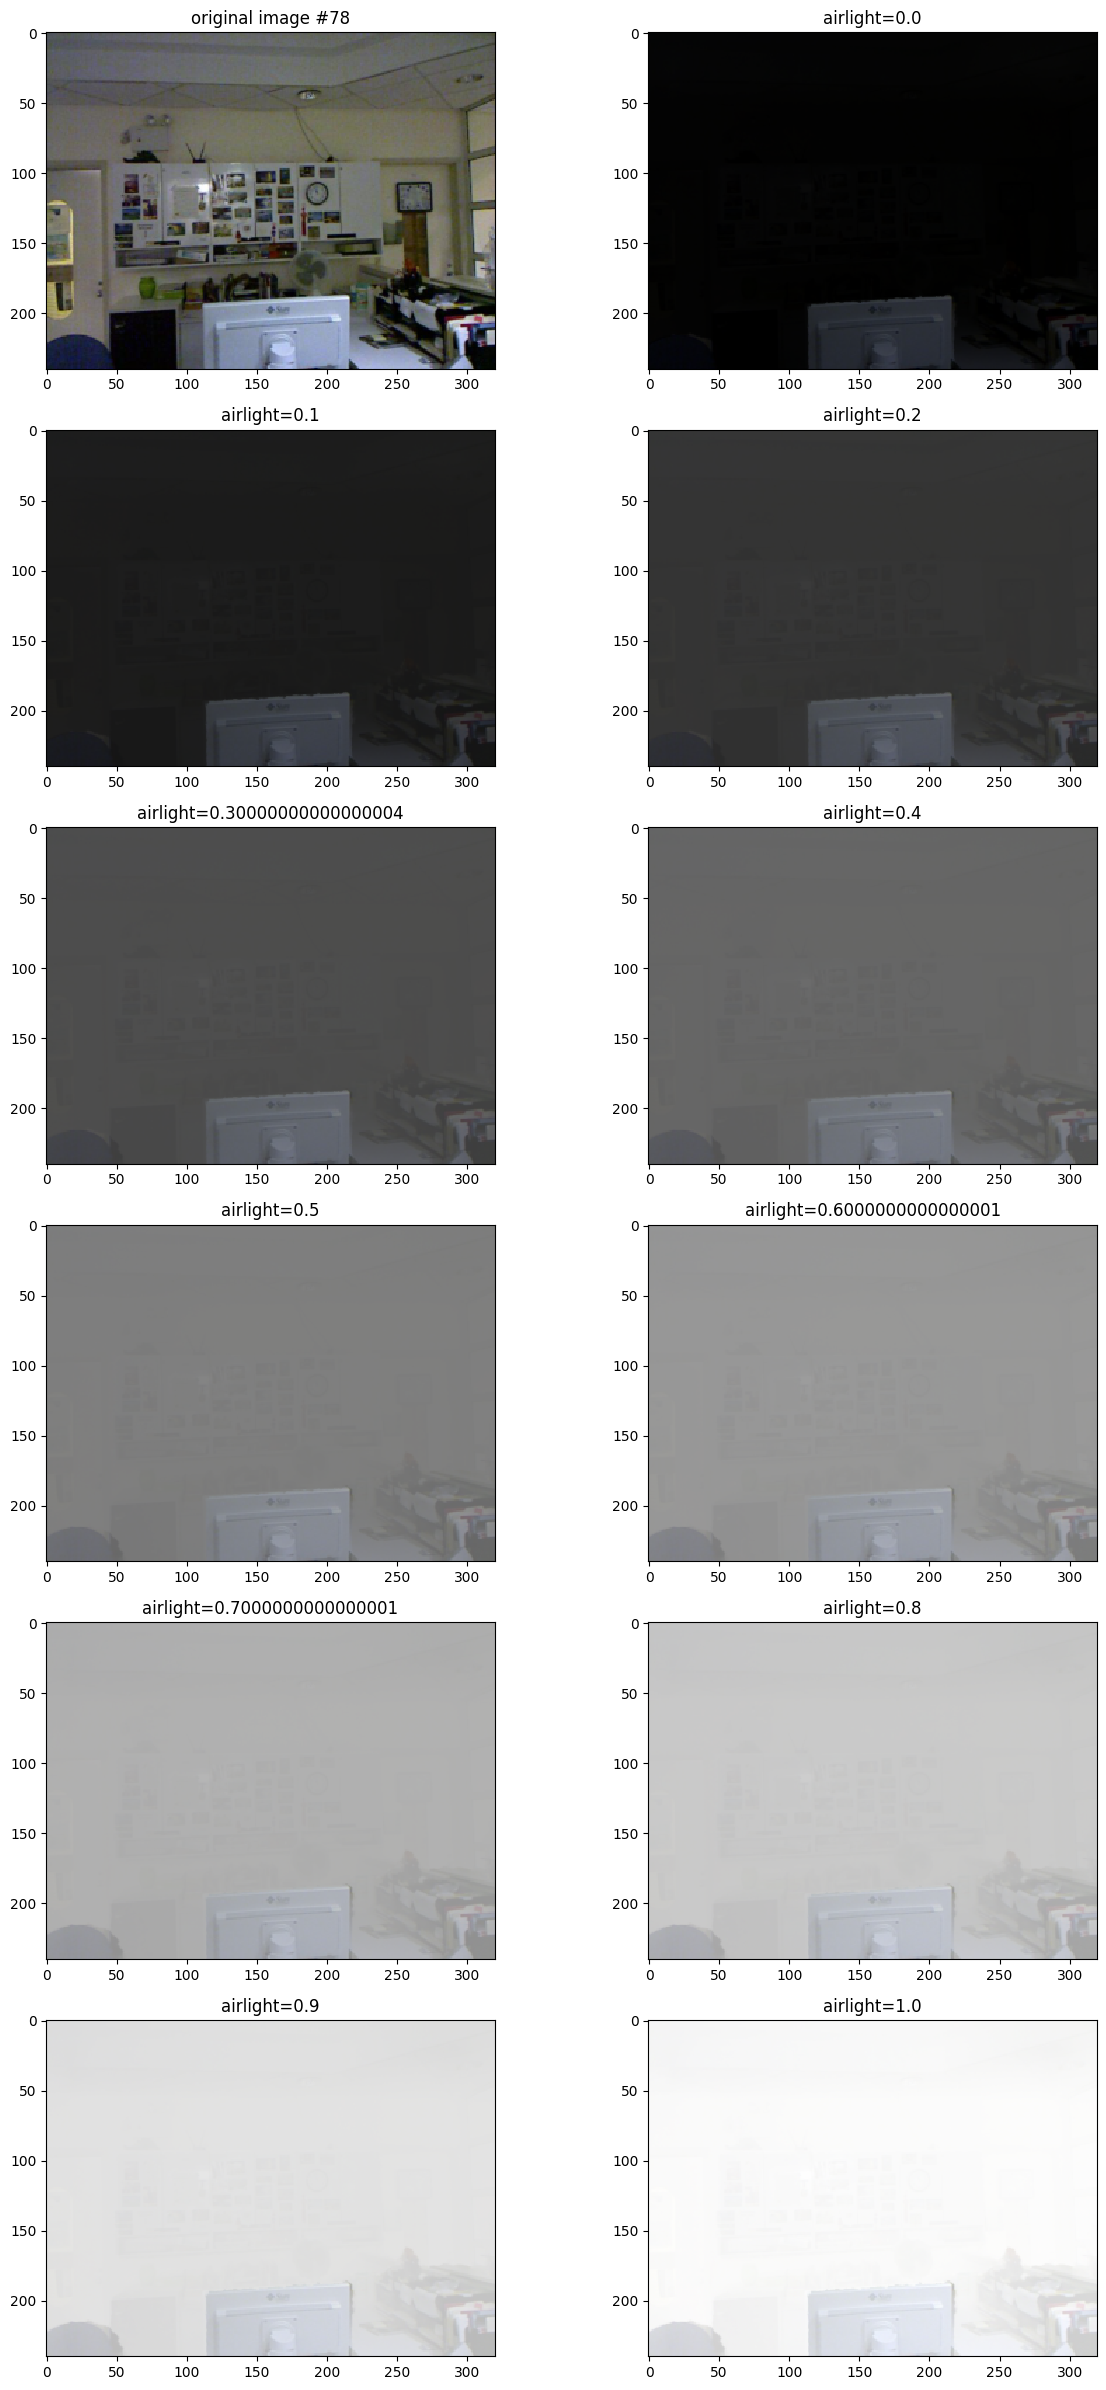

In [7]:
scatt_coeff=1.0
fig,axes=plt.subplots(6,2,squeeze=False,figsize=(15,4*6))
im,im_depth=get_processed_image(input_file,s_idx)
print("Scattering coefficient :",scatt_coeff)
for k in range(0,12):
    myax=axes[math.floor(k/2)][k%2]
    if k==0:
        myax.set_title("original image #"+str(s_idx))
        skio.imshow(im,ax=myax)
        continue
    aval=(k-1)*0.1
    myax.set_title("airlight="+str(aval))
    airlight=np.array([aval]*3)
    hazy_im,trans_map=generate_hazy_image(im,im_depth,airlight,scatt_coeff)
    skio.imshow(hazy_im,ax=myax)

In [8]:
np.min(hazy_im)

0.7288267093484806

Now, let's do the same for the scattering coefficient

Airlight : 0.85


c:\Users\heman\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


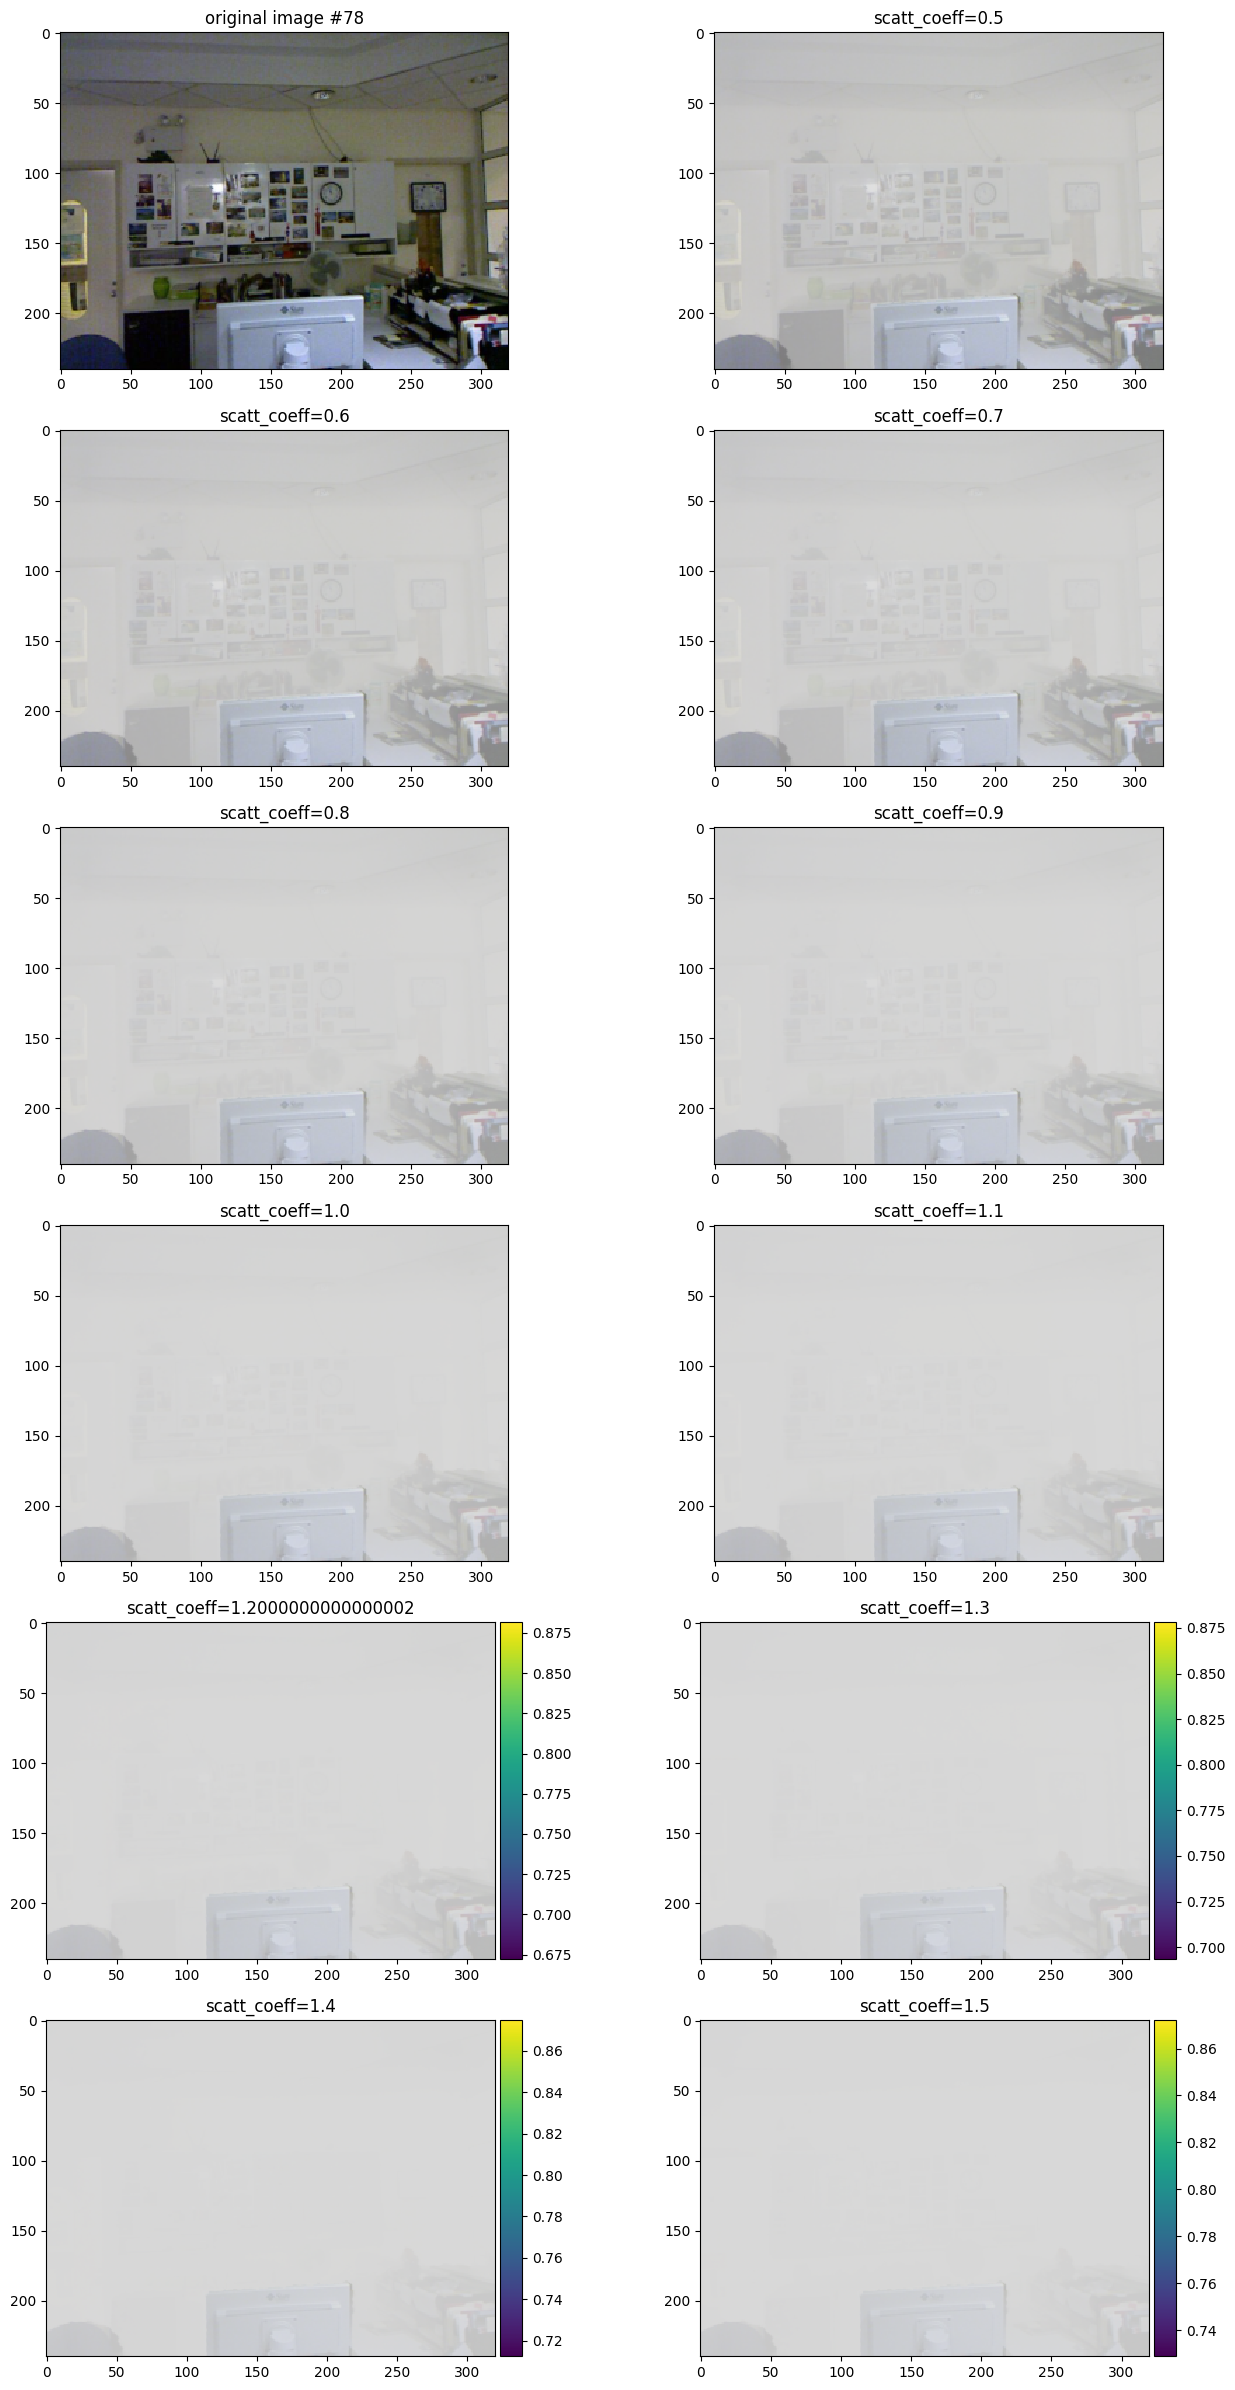

In [9]:
aval=0.85
fig,axes=plt.subplots(6,2,squeeze=False,figsize=(15,4*6))
im,im_depth=get_processed_image(input_file,s_idx)
print("Airlight :",aval)
for k in range(0,12):
    myax=axes[math.floor(k/2)][k%2]
    if k==0:
        myax.set_title("original image #"+str(s_idx))
        skio.imshow(im,ax=myax)
        continue
    scatt_coeff=(k-1)*0.1 + 0.5
    myax.set_title("scatt_coeff="+str(scatt_coeff))
    airlight=np.array([aval]*3)
    hazy_im,trans_map=generate_hazy_image(im,im_depth,airlight,scatt_coeff)
    skio.imshow(hazy_im,ax=myax)

### Generating the training set

Now let's generate our hazy images dataset and save it as an hdf5 file!

In [10]:
def generate_hazy_dataset(input_file,sample_idcs,output_path,num_airlights,num_scats,
                             a_high=1.0,a_low=0.7,
                             scatt_high=1.2,scatt_low=0.5):
    # read input file
    _,num_channels,width,height=input_file["images"].shape
    num_samples=len(sample_idcs)
    # prepare output file
    output_file = h5py.File(output_path,"w")
    output_file.create_dataset("airlight", (num_samples,),dtype="float32")
    output_file.create_dataset("scatt_coeff", (num_samples,),dtype="float32")
    output_file.create_dataset("image", (num_samples,int(height/2),int(width/2),num_channels),dtype="float32")
    output_file.create_dataset("hazy_image", (num_samples,int(height/2),int(width/2),num_channels),dtype="float32")
    output_file.create_dataset("trans_map", (num_samples,int(height/2),int(width/2)),dtype="float32")
    # generate
    for s_idx,inp_idx in tqdm(enumerate(sample_idcs)):
        im,im_depth=get_processed_image(input_file,inp_idx)
        output_file["image"][s_idx]=im
        for j in range(0,num_airlights):
            airlight=np.zeros(num_channels)+(a_high-a_low)*np.random.random()+a_low
            output_file["airlight"][s_idx]=airlight[0]
            for k in range(0,num_scats):
                scatt_coeff=(scatt_high-scatt_low)*np.random.random()+scatt_low
                output_file["scatt_coeff"][s_idx]=scatt_coeff
                hazy_im,trans_map=generate_hazy_image(im,im_depth,airlight,scatt_coeff)
                output_file["hazy_image"][s_idx]=hazy_im
                output_file["trans_map"][s_idx]=trans_map
    output_file.close()

In [11]:
NUM_TEST=40
trn_output_path="../data/nyu_hazy_trn.mat"
tst_output_path="../data/nyu_hazy_tst.mat"
shuffle=np.random.permutation(input_file["images"].shape[0])
trn_idcs=shuffle[NUM_TEST:]
tst_idcs=shuffle[:NUM_TEST]
generate_hazy_dataset(input_file,trn_idcs,trn_output_path,1,3)
generate_hazy_dataset(input_file,tst_idcs,tst_output_path,1,3)

2244it [02:00, 18.58it/s]
40it [00:02, 18.40it/s]


Let's check if it worked.

airlight
<HDF5 dataset "airlight": shape (40,), type "<f4">
hazy_image
<HDF5 dataset "hazy_image": shape (40, 240, 320, 3), type "<f4">
image
<HDF5 dataset "image": shape (40, 240, 320, 3), type "<f4">
scatt_coeff
<HDF5 dataset "scatt_coeff": shape (40,), type "<f4">
trans_map
<HDF5 dataset "trans_map": shape (40, 240, 320), type "<f4">


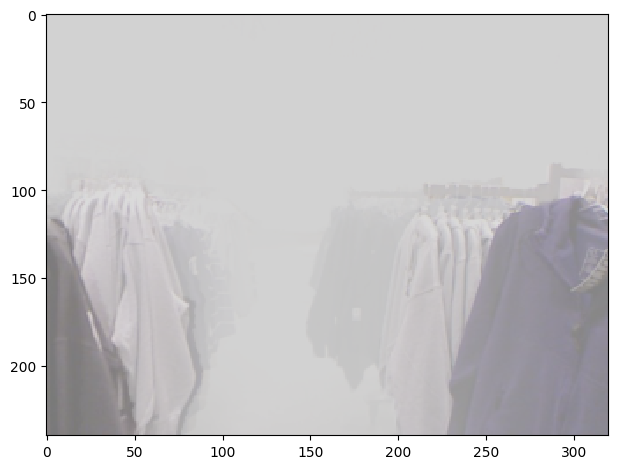

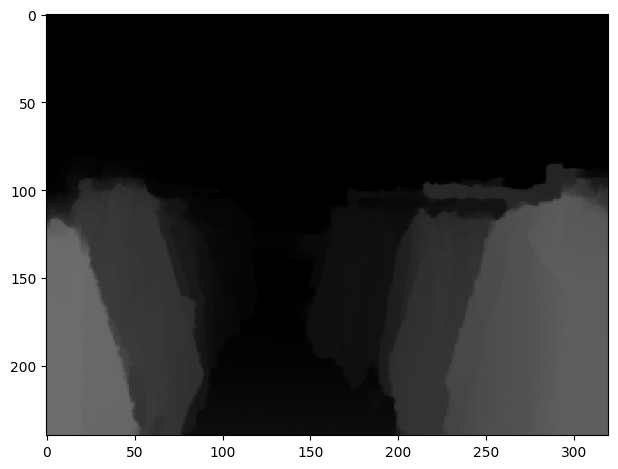

In [12]:
hazy_file = h5py.File(tst_output_path,"r")
for name,var in hazy_file.items():
    print(name)
    print(var)
hazy_im=hazy_file["hazy_image"][0,:,:,:]
plt.figure()
skio.imshow(hazy_im)
tmap=hazy_file["trans_map"][0,:,:]
plt.figure()
skio.imshow(tmap)

Cleanup...

In [14]:
input_file.close()
hazy_file.close()